In [1]:
from local_vars import root_folder

data_folder = r"Circles"
image_size = 64
batch_size = 20
input_intensity_scaling = 1 / 255.0

In [2]:
import pandas as pd
import numpy as np
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   c:\Temp\Circles\train
Validation data folder: c:\Temp\Circles\valid
Test data folder:       c:\Temp\Circles\test


In [4]:
train_annotations_df = pd.DataFrame()

num_csv_files = 0
for file_name in os.listdir(train_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(train_fullpath, file_name)
    train_annotations_df = pd.concat([train_annotations_df, pd.read_csv(current_file_path)])

valid_annotations_df = pd.DataFrame()

for file_name in os.listdir(valid_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(valid_fullpath, file_name)
    valid_annotations_df = pd.concat([valid_annotations_df, pd.read_csv(current_file_path)])

test_annotations_df = pd.DataFrame()

for file_name in os.listdir(test_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(test_fullpath, file_name)
    test_annotations_df = pd.concat([test_annotations_df, pd.read_csv(current_file_path)])

num_test_images = test_annotations_df.shape[0]
    
print("Number of training images:   {}".format(train_annotations_df.shape[0]))
print("Number of validation images: {}".format(valid_annotations_df.shape[0]))
print("Number of test images:       {}".format(num_test_images))

Number of training images:   10000
Number of validation images: 200
Number of test images:       200


In [5]:
annot_data = train_annotations_df[:5]
print("Original annotations")
print(annot_data)

scaled_positions = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
scaled_positions.columns = ['x', 'y']

# scaled_positions = np.concatenate( annot_data[:,2] / annot_data[:,0], annot_data[:,3] / annot_data[:,1], axis=1)
print("\nScaled positions")
print(scaled_positions)

Original annotations
   Unnamed: 0   filename  width  height  class    x    y
0           0  00000.png    128     128      1   19   81
1           1  00001.png    128     128      1   18  111
2           2  00002.png    128     128      1  103   10
3           3  00003.png    128     128      1  101   38
4           4  00004.png    128     128      1   29   87

Scaled positions
          x         y
0  0.148438  0.632812
1  0.140625  0.867188
2  0.804688  0.078125
3  0.789062  0.296875
4  0.226562  0.679688


In [6]:
class MyBatchGenerator(Sequence):
    
    def __init__(self, image_filenames, annotations_df, batch_size, image_size=256):
        self.image_filenames, self.annotations_df = image_filenames, annotations_df
        self.batch_size = batch_size
    
    def __len__(self):
        num_batches = np.ceil(len(self.image_filenames) / float(self.batch_size))
        return int(num_batches)
    
    def __getitem__(self, idx):
        from_index = idx * self.batch_size
        to_index = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[from_index:to_index]
        annot_data = self.annotations_df[['width', 'height', 'x', 'y']].iloc[from_index:to_index]
        batch_y = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
        return np.array([
            resize(
                imread(file_name) * input_intensity_scaling,
                (image_size, image_size, 1),
                anti_aliasing=False,
                preserve_range=True,
                mode='constant') for file_name in batch_x]),  np.array(batch_y)

In [7]:
train_image_filenames = [os.path.join(train_fullpath,fn) for fn in os.listdir(train_fullpath) if fn.endswith('png')]
valid_image_filenames = [os.path.join(valid_fullpath,fn) for fn in os.listdir(valid_fullpath) if fn.endswith('png')]
test_image_filenames = [os.path.join(test_fullpath,fn) for fn in os.listdir(test_fullpath) if fn.endswith('png')]

In [8]:
train_generator = MyBatchGenerator(train_image_filenames, train_annotations_df, batch_size, image_size)
valid_generator = MyBatchGenerator(valid_image_filenames, valid_annotations_df, batch_size, image_size)

Example input image with true location

Validation locations
[[0.7265625 0.359375 ]
 [0.203125  0.9296875]
 [0.7734375 0.125    ]
 [0.203125  0.546875 ]
 [0.1484375 0.8046875]]


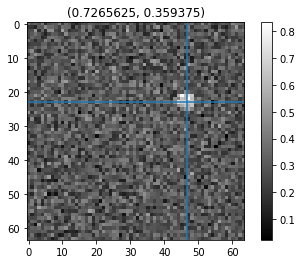

In [9]:
x, y = valid_generator.__getitem__(0)

print("Example input image with true location")
plt.title(str((y[0][0], y[0][1])))
plt.imshow(x[0][:,:,0], cmap='gray')
plt.axvline(x=y[0][0] * image_size)
plt.axhline(y=y[0][1] * image_size)
out = plt.colorbar()

print("\nValidation locations")
print(y[:5])

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
__________

In [11]:
num_validation_steps = valid_annotations_df.shape[0] // batch_size
num_steps = train_annotations_df.shape[0] // batch_size

print("Training steps:   {}".format(num_steps))
print("Validation steps: {}".format(num_validation_steps))

Training steps:   500
Validation steps: 10


In [12]:
model.compile(SGD(lr=.1), loss='mse', metrics=['accuracy'])

In [13]:
num_epochs = 8

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=num_steps,
    epochs=num_epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=num_validation_steps)

Epoch 1/8
500/500 [==============================] - 14s 28ms/step - loss: 0.0681 - acc: 0.5091 - val_loss: 0.0702 - val_acc: 0.4850
Epoch 2/8
500/500 [==============================] - 12s 23ms/step - loss: 0.0608 - acc: 0.6929 - val_loss: 0.0128 - val_acc: 0.9600
Epoch 3/8
500/500 [==============================] - 12s 23ms/step - loss: 0.0072 - acc: 0.9535 - val_loss: 0.0046 - val_acc: 0.9750
Epoch 4/8
500/500 [==============================] - 11s 22ms/step - loss: 0.0044 - acc: 0.9571 - val_loss: 0.0031 - val_acc: 0.9850
Epoch 5/8
500/500 [==============================] - 11s 22ms/step - loss: 0.0036 - acc: 0.9630 - val_loss: 0.0028 - val_acc: 0.9750
Epoch 6/8
500/500 [==============================] - 11s 22ms/step - loss: 0.0031 - acc: 0.9655 - val_loss: 0.0026 - val_acc: 0.9950
Epoch 7/8
500/500 [==============================] - 11s 22ms/step - loss: 0.0026 - acc: 0.9672 - val_loss: 0.0023 - val_acc: 0.9950
Epoch 8/8
500/500 [==============================] - 11s 22ms/step - 

Text(0.5,1,'Accuracy Curves')

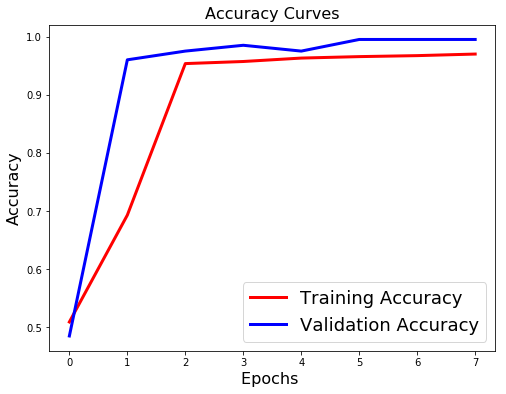

In [14]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [15]:
test_generator = MyBatchGenerator(test_image_filenames, test_annotations_df, num_test_images, image_size)

In [16]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

In [17]:
x, y = test_generator.__getitem__(0)
y_pred = model.predict(x)

n = len(y)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(y)):
    distance = np.linalg.norm(y[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

print("\nTrue locations")
print(y[:5])

print("\nPredicted locations")
print(y_pred[:5])

Average error: 0.0534

True locations
[[0.7421875 0.3125   ]
 [0.78125   0.6171875]
 [0.8046875 0.7578125]
 [0.8125    0.4375   ]
 [0.640625  0.5078125]]

Predicted locations
[[0.73501986 0.32626298]
 [0.7232419  0.5768829 ]
 [0.8002607  0.7529743 ]
 [0.8153966  0.45864937]
 [0.60767305 0.5155177 ]]


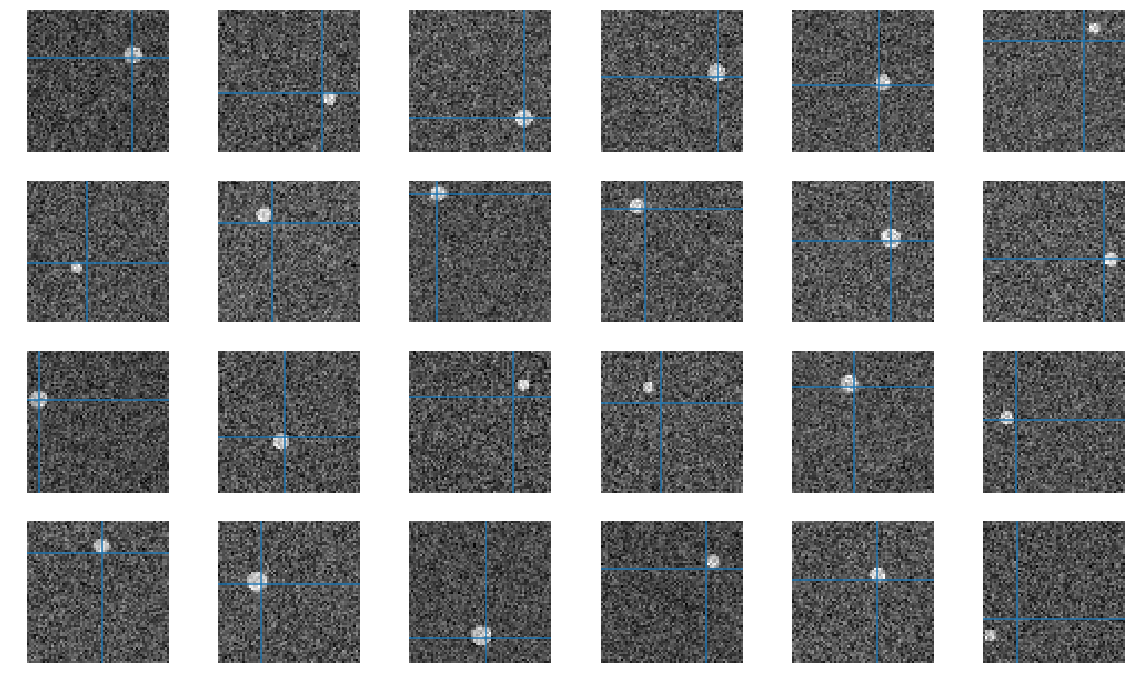

In [18]:
plots(x[:24], y_pred[:24], figsize=(20,12), rows=4)

In [19]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)